In [1]:
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse

In [2]:
# Load data
data = pd.read_csv(r"C:\Users\sneha\Downloads\FaceExpressions\data.csv")
faces_dir = r"C:\Users\sneha\Downloads\FaceExpressions\dataset"

In [3]:
# Define input shape and image size
input_shape = (128, 128)
img_size = 128

In [4]:
# Define train, validation, and test ratios
TRAIN_RATIO, TEST_RATIO = 0.8, 0.2

In [5]:
# Define folder paths and constants
#target_img_path = "/Users/hemanthalaparthi/Downloads/FaceExpressions/resized_images"
batch_size = 32

In [6]:
# Adjust input shape to match the desired image size
input_shape = (img_size, img_size)

In [7]:
from os import listdir
classes=sorted(listdir(faces_dir))
print(classes)

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [8]:
# Load images from all categories
image_files = []
for category in classes:
    category_path = os.path.join(faces_dir, category)
    image_files.extend(glob(os.path.join(category_path, "*")))

In [9]:
# Load images from all categories, but limit to 250 images per category
image_files = []
max_images_per_category = 600  # Maximum number of images to load per category

for category in classes:
    category_path = os.path.join(faces_dir, category)
    category_images = glob(os.path.join(category_path, "*"))
    # Limit the number of images loaded to max_images_per_category
    if len(category_images) > max_images_per_category:
        category_images = category_images[:max_images_per_category]
    image_files.extend(category_images)

# Proceed with the rest of your code for shuffling, splitting, etc.


In [10]:
# Shuffle the list of image files
np.random.shuffle(image_files)

In [11]:
len(image_files)

3600

In [12]:
# Split the dataset into train, validation, and test sets
train_size = int(len(image_files) * TRAIN_RATIO)
test_size = int(len(image_files) * TEST_RATIO)

train_files = image_files[:train_size]
test_files = image_files[train_size:train_size + test_size]

In [13]:
# Load images and preprocess
def preprocess_image(image):
    image = cv2.resize(image, (img_size, img_size))
    image = image.astype('float32') / 255.
    return image

In [14]:
# Load train and test images
x_train = np.array([preprocess_image(cv2.imread(file)) for file in train_files])
x_test = np.array([preprocess_image(cv2.imread(file)) for file in test_files])

In [15]:
# Define input shape and latent dimension
latent_dim = 2
input_shape = (img_size, img_size, 3)

# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

#shape_before_flattening = x.shape[1:]  # Getting shape before flattening directly
shape_before_flattening = tf.keras.backend.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [33]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

In [17]:
# Decoder network
decoder_input = Input(tf.keras.backend.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [18]:
# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae_model = Model(inputs, outputs, name='vae')

In [19]:
# Define the VAE loss function
reconstruction_loss = mse(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
reconstruction_loss *= img_size * img_size * 3
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

In [20]:
# Compile the model
vae_model.add_loss(vae_loss)
vae_model.compile(optimizer='adam')

In [22]:
# Train the VAE model
vae_history = vae_model.fit(x_train, epochs=5, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/5
90/90 [==============================] - 931s 10s/step - loss: 2199.6301 - val_loss: 2211.4592
Epoch 2/5
90/90 [==============================] - 979s 11s/step - loss: 2181.1123 - val_loss: 2209.7629
Epoch 3/5
90/90 [==============================] - 593s 7s/step - loss: 2175.0781 - val_loss: 2200.3882
Epoch 4/5
90/90 [==============================] - 448s 5s/step - loss: 2169.5110 - val_loss: 2202.8962
Epoch 5/5
90/90 [==============================] - 460s 5s/step - loss: 2170.8140 - val_loss: 2203.5320


23/23 [==============================] - 26s 1s/step


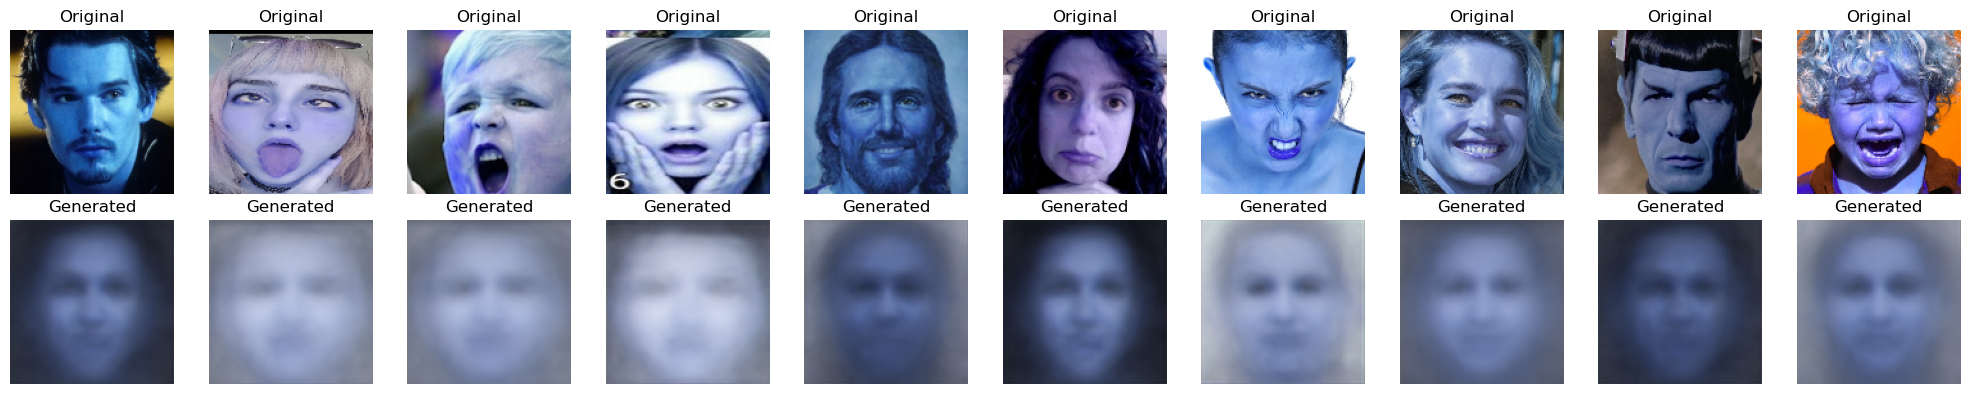

In [23]:
import matplotlib.pyplot as plt
# Assuming vae_model and x_test are defined earlier in the code

# Reconstruct test images using the trained VAE model
generated_imgs = vae_model.predict(x_test)

# Number of images to display
n = 10  # Change n to the number of images you want to display, make sure it's <= len(x_test)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size, 3))
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed image
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(generated_imgs[i].reshape(img_size, img_size, 3))
    plt.title("Generated")
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [24]:
vae_model.save(r"C:\Users\sneha\Downloads\my_model.h5")

In [30]:
# Train the VAE model
vae_history1 = vae_model.fit(x_train, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
90/90 [==============================] - 388s 4s/step - loss: 2164.1865 - val_loss: 2216.7380
Epoch 2/10
90/90 [==============================] - 450s 5s/step - loss: 2159.3130 - val_loss: 2216.4258
Epoch 3/10
90/90 [==============================] - 443s 5s/step - loss: 2154.3103 - val_loss: 2203.5366
Epoch 4/10
90/90 [==============================] - 446s 5s/step - loss: 2149.8169 - val_loss: 2199.7124
Epoch 5/10
90/90 [==============================] - 439s 5s/step - loss: 2149.9944 - val_loss: 2198.0266
Epoch 6/10
90/90 [==============================] - 437s 5s/step - loss: 2148.3496 - val_loss: 2204.1069
Epoch 7/10
90/90 [==============================] - 439s 5s/step - loss: 2139.6440 - val_loss: 2206.8379
Epoch 8/10
90/90 [==============================] - 430s 5s/step - loss: 2136.4656 - val_loss: 2203.3770
Epoch 9/10
90/90 [==============================] - 429s 5s/step - loss: 2128.1287 - val_loss: 2212.2473
Epoch 10/10
90/90 [==============================] - 11

23/23 [==============================] - 35s 2s/step


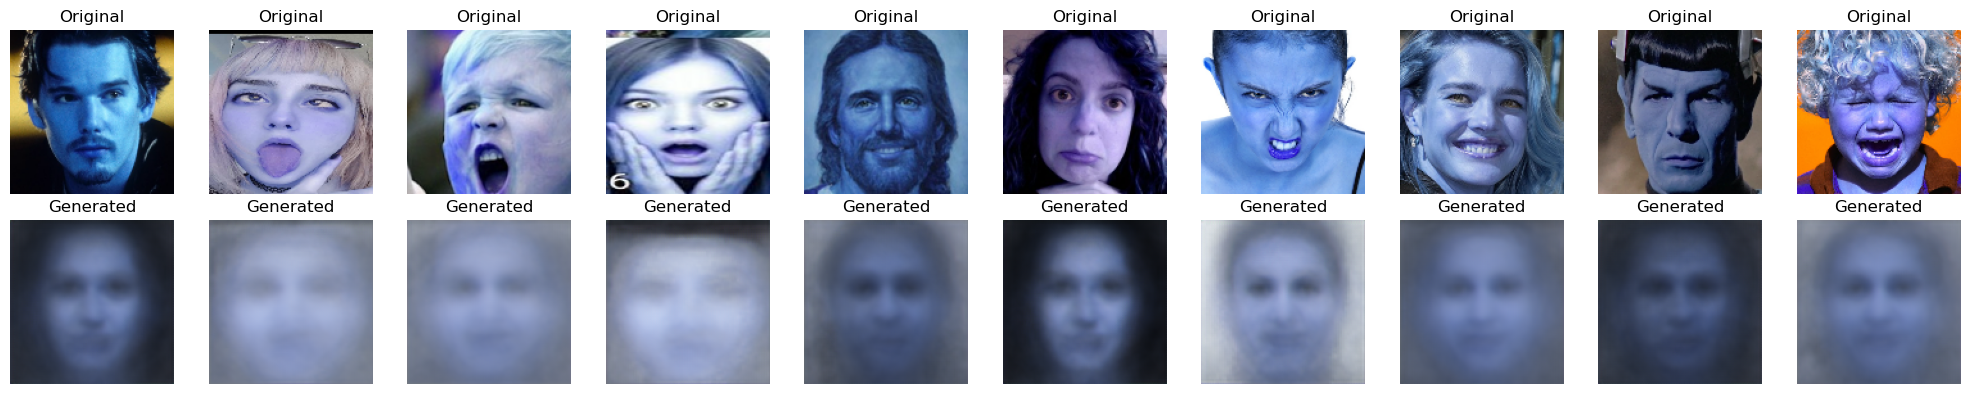

In [31]:
import matplotlib.pyplot as plt
# Assuming vae_model and x_test are defined earlier in the code

# Reconstruct test images using the trained VAE model
generated_imgs = vae_model.predict(x_test)

# Number of images to display
n = 10  # Change n to the number of images you want to display, make sure it's <= len(x_test)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size, 3))
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed image
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(generated_imgs[i].reshape(img_size, img_size, 3))
    plt.title("Generated")
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
